# Smart Laptop Advisor - ML Pipeline

## Laptop Price Prediction using Machine Learning

**Dataset:** Kaggle - Laptop Price Estimation (Indian Market - INR)  
**Algorithms:** Linear Regression, Random Forest, Gradient Boosting

---

### Table of Contents
1. [Import Libraries](#1-import-libraries)
2. [Load Dataset](#2-load-dataset)
3. [Exploratory Data Analysis (EDA)](#3-exploratory-data-analysis)
4. [Data Preprocessing](#4-data-preprocessing)
5. [Feature Engineering](#5-feature-engineering)
6. [Model Training](#6-model-training)
7. [Model Evaluation](#7-model-evaluation)
8. [Feature Importance](#8-feature-importance)
9. [Conclusion](#9-conclusion)

---
## 1. Import Libraries

In [4]:
# Thư viện xử lý dữ liệu
import pandas as pd
import numpy as np

# Thư viện trực quan hóa
import matplotlib.pyplot as plt
import seaborn as sns

# Thư viện Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Tắt cảnh báo
import warnings
warnings.filterwarnings('ignore')

# Cài đặt style biểu đồ
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print('Đã import thành công tất cả thư viện!')

Đã import thành công tất cả thư viện!


---
## 2. Load Dataset

In [ ]:
# Tải dataset
# Thay đổi đường dẫn phù hợp với vị trí file của bạn
df = pd.read_csv('\data\laptop_prices.csv')

print(f'Kích thước dataset: {df.shape}')
print(f'Các cột: {df.columns.tolist()}')
print(f'\n5 dòng đầu tiên:')
df.head()

Kích thước dataset: (893, 13)
Các cột: ['Company', 'Product', 'Cpu', 'Ram', 'Gpu', 'OpSys', 'Inches', 'Price', 'Cpu_brand', 'Gpu_brand', 'HDD', 'SSD', 'LogPrice']

5 dòng đầu tiên:


,Company,Product,Cpu,Ram,Gpu,OpSys,Inches,Price,Cpu_brand,Gpu_brand,HDD,SSD,LogPrice
0,HP,Victus 15-fb0157AX Gaming Laptop,"Hexa Core, 12 Threads",8,4GB AMD Radeon RX 6500M,Windows 11 OS,15.6,49900,"Hexa Core,",4GB,0,512,10.817776
1,HP,15s-fq5007TU Laptop,"Hexa Core (2P + 4E), 8 Threads",8,Intel UHD Graphics,Windows 11 OS,15.6,39900,Hexa Core,Intel,0,512,10.594132
2,Acer,One 14 Z8-415 Laptop,"Dual Core, 4 Threads",8,Intel Iris Xe Graphics,Windows 11 OS,14.0,26990,"Dual Core,",Intel,0,512,10.203222
3,Lenovo,Yoga Slim 6 14IAP8 82WU0095IN Laptop,"12 Cores (4P + 8E), 16 Threads",16,Intel Integrated Iris Xe,Windows 11 OS,14.0,59729,12 Cores,Intel,0,512,10.997573
4,Apple,MacBook Air 2020 MGND3HN Laptop,Octa Core (4P + 4E),8,Apple M1 Integrated Graphics,Mac OS,13.3,69990,Octa Core,Apple,0,256,11.156108


In [6]:
# Thông tin dataset
print('Thông tin Dataset:')
print('=' * 50)
df.info()

Thông tin Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Company    893 non-null    object 
 1   Product    893 non-null    object 
 2   Cpu        893 non-null    object 
 3   Ram        893 non-null    int64  
 4   Gpu        893 non-null    object 
 5   OpSys      893 non-null    object 
 6   Inches     893 non-null    float64
 7   Price      893 non-null    int64  
 8   Cpu_brand  893 non-null    object 
 9   Gpu_brand  893 non-null    object 
 10  HDD        893 non-null    int64  
 11  SSD        893 non-null    int64  
 12  LogPrice   893 non-null    float64
dtypes: float64(2), int64(4), object(7)
memory usage: 90.8+ KB


In [7]:
# Thống kê mô tả
print('Thống kê mô tả:')
df.describe()

Thống kê mô tả:


,Ram,Inches,Price,HDD,SSD,LogPrice
count,893.000000,893.000000,893.000000,893.0,893.000000,893.000000
mean,13.251960,15.173751,79907.409854,0.0,594.293393,11.090972
std,6.476961,0.939095,60880.043823,0.0,275.529802,0.601362
min,2.000000,11.600000,9999.000000,0.0,0.000000,9.210240
25%,8.000000,14.000000,44500.000000,0.0,512.000000,10.703244
50%,16.000000,15.600000,61990.000000,0.0,512.000000,11.034728
75%,16.000000,15.600000,90990.000000,0.0,512.000000,11.418505
max,64.000000,18.000000,450039.000000,0.0,2000.000000,13.017090


---
## 3. Exploratory Data Analysis

### 3.1 Missing Values Analysis

In [8]:
# Kiểm tra giá trị thiếu
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Số lượng thiếu': missing,
    'Tỷ lệ (%)': missing_pct
})

print('Phân tích giá trị thiếu:')
print('=' * 50)
print(missing_df[missing_df['Số lượng thiếu'] > 0])

if missing.sum() == 0:
    print('\nKhông có giá trị thiếu!')

Phân tích giá trị thiếu:
Empty DataFrame
Columns: [Số lượng thiếu, Tỷ lệ (%)]
Index: []

Không có giá trị thiếu!


### 3.2 Target Variable Analysis (Price)

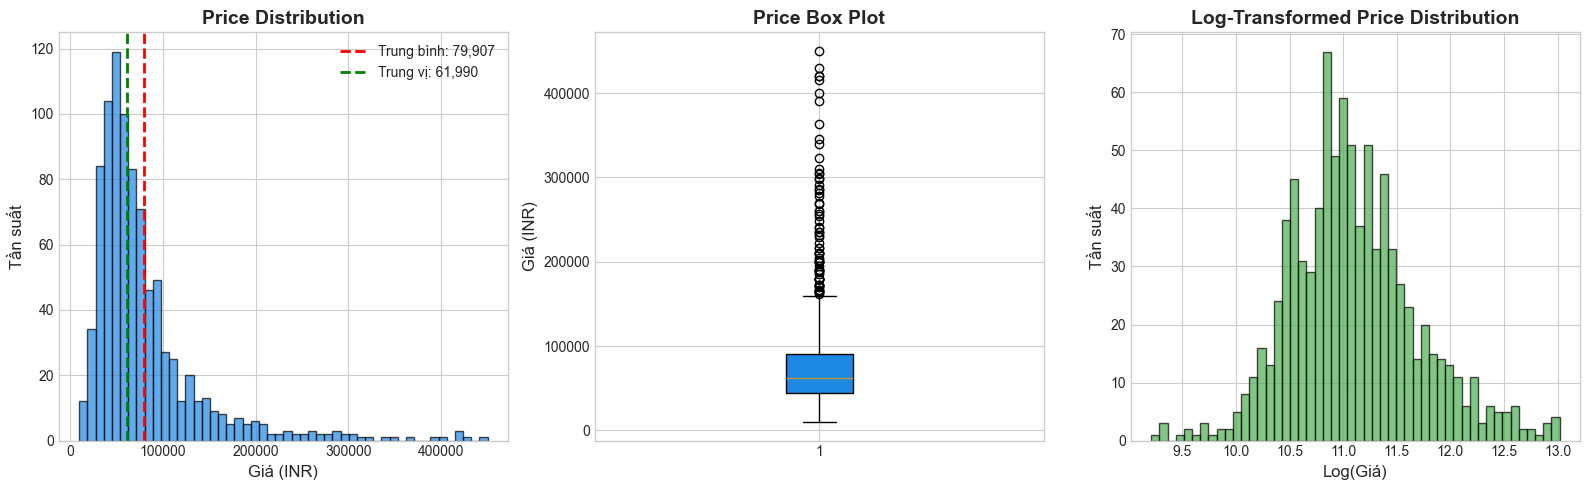


Thống kê Giá (INR):
   Trung bình:       79,907
   Trung vị:         61,990
   Độ lệch:          60,880
   Nhỏ nhất:          9,999
   Lớn nhất:        450,039


In [9]:
# Phân phối giá
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Histogram
axes[0].hist(df['Price'], bins=50, edgecolor='black', alpha=0.7, color='#1E88E5')
axes[0].axvline(df['Price'].mean(), color='red', linestyle='--', linewidth=2, label=f'Trung bình: {df["Price"].mean():,.0f}')
axes[0].axvline(df['Price'].median(), color='green', linestyle='--', linewidth=2, label=f'Trung vị: {df["Price"].median():,.0f}')
axes[0].set_xlabel('Giá (INR)', fontsize=12)
axes[0].set_ylabel('Tần suất', fontsize=12)
axes[0].set_title('Price Distribution', fontsize=14, fontweight='bold')
axes[0].legend()

# Box plot
bp = axes[1].boxplot(df['Price'], patch_artist=True)
bp['boxes'][0].set_facecolor('#1E88E5')
axes[1].set_ylabel('Giá (INR)', fontsize=12)
axes[1].set_title('Price Box Plot', fontsize=14, fontweight='bold')

# Log distribution
axes[2].hist(np.log1p(df['Price']), bins=50, edgecolor='black', alpha=0.7, color='#4CAF50')
axes[2].set_xlabel('Log(Giá)', fontsize=12)
axes[2].set_ylabel('Tần suất', fontsize=12)
axes[2].set_title('Log-Transformed Price Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Thống kê giá
print('\nThống kê Giá (INR):')
print('=' * 40)
print(f'   Trung bình: {df["Price"].mean():>12,.0f}')
print(f'   Trung vị:   {df["Price"].median():>12,.0f}')
print(f'   Độ lệch:    {df["Price"].std():>12,.0f}')
print(f'   Nhỏ nhất:   {df["Price"].min():>12,.0f}')
print(f'   Lớn nhất:   {df["Price"].max():>12,.0f}')

### 3.3 Categorical Features Analysis

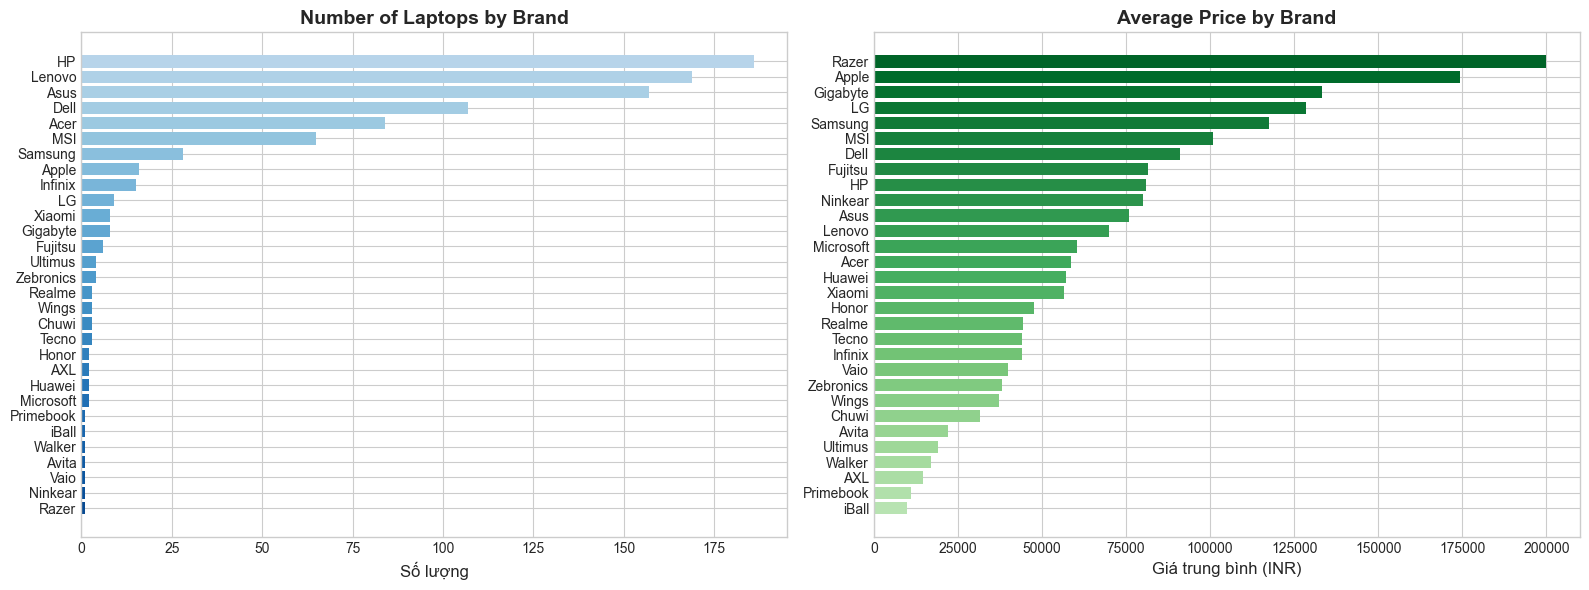

In [10]:
# Phân phối thương hiệu
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Số lượng theo thương hiệu
brand_counts = df['Company'].value_counts()
colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(brand_counts)))
axes[0].barh(brand_counts.index, brand_counts.values, color=colors)
axes[0].set_xlabel('Số lượng', fontsize=12)
axes[0].set_title('Number of Laptops by Brand', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Giá trung bình theo thương hiệu
brand_price = df.groupby('Company')['Price'].mean().sort_values(ascending=True)
colors = plt.cm.Greens(np.linspace(0.3, 0.9, len(brand_price)))
axes[1].barh(brand_price.index, brand_price.values, color=colors)
axes[1].set_xlabel('Giá trung bình (INR)', fontsize=12)
axes[1].set_title('Average Price by Brand', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

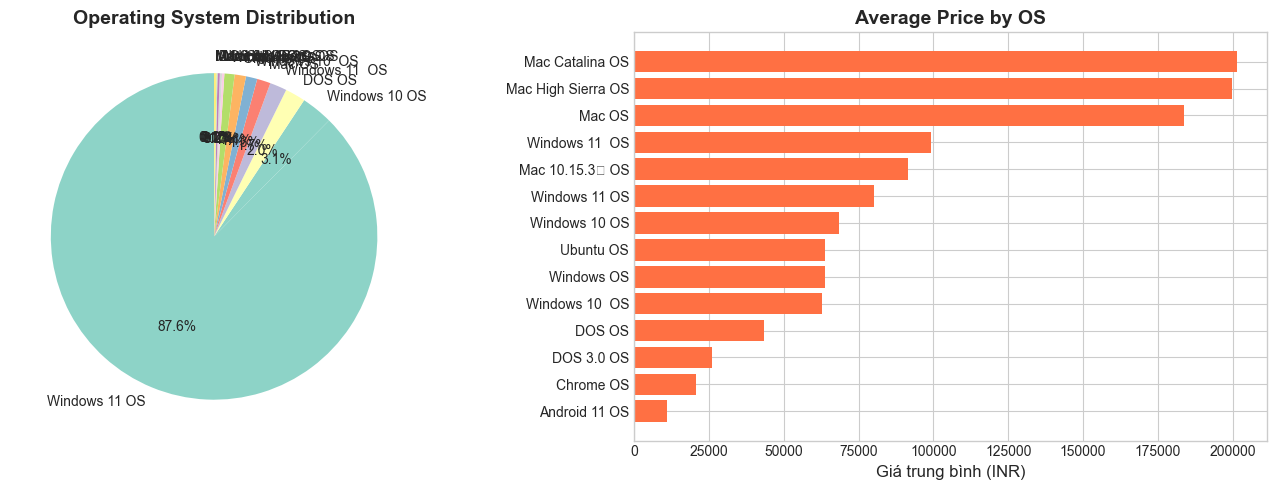

In [11]:
# Phân phối hệ điều hành
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ tròn
os_counts = df['OpSys'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(os_counts)))
axes[0].pie(os_counts.values, labels=os_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
axes[0].set_title('Operating System Distribution', fontsize=14, fontweight='bold')

# Giá trung bình theo OS
os_price = df.groupby('OpSys')['Price'].mean().sort_values(ascending=True)
axes[1].barh(os_price.index, os_price.values, color='#FF7043')
axes[1].set_xlabel('Giá trung bình (INR)', fontsize=12)
axes[1].set_title('Average Price by OS', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 3.4 Numerical Features Analysis

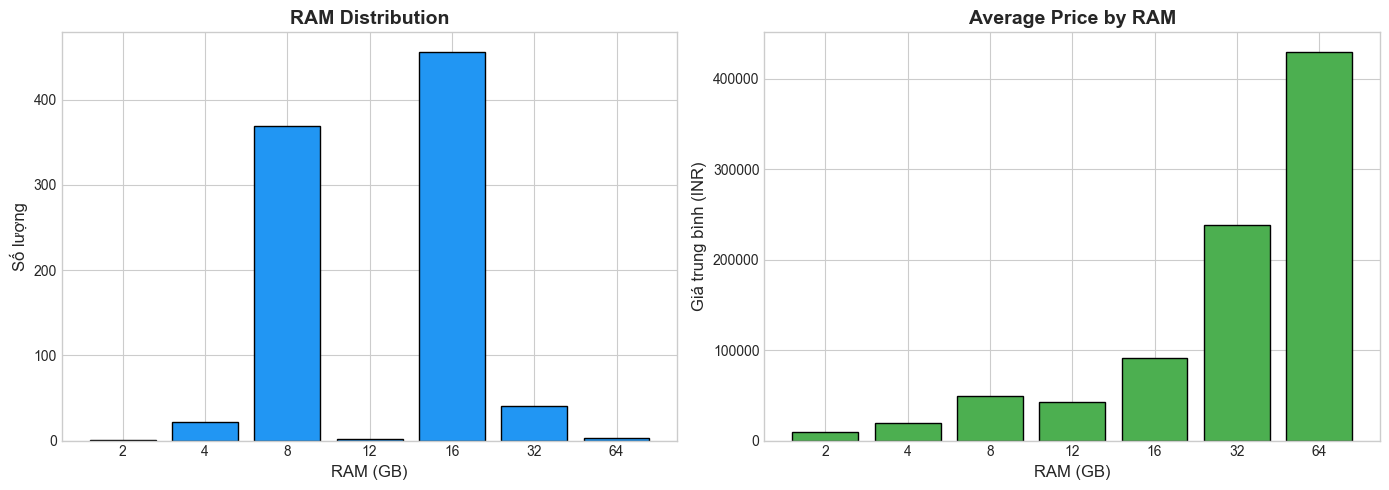

In [12]:
# RAM vs Giá
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Phân phối RAM
ram_counts = df['Ram'].value_counts().sort_index()
axes[0].bar(ram_counts.index.astype(str), ram_counts.values, color='#2196F3', edgecolor='black')
axes[0].set_xlabel('RAM (GB)', fontsize=12)
axes[0].set_ylabel('Số lượng', fontsize=12)
axes[0].set_title('RAM Distribution', fontsize=14, fontweight='bold')

# Giá trung bình theo RAM
ram_price = df.groupby('Ram')['Price'].mean().sort_index()
axes[1].bar(ram_price.index.astype(str), ram_price.values, color='#4CAF50', edgecolor='black')
axes[1].set_xlabel('RAM (GB)', fontsize=12)
axes[1].set_ylabel('Giá trung bình (INR)', fontsize=12)
axes[1].set_title('Average Price by RAM', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 3.5 Correlation Analysis

Các cột số: ['Ram', 'Inches', 'Price', 'HDD', 'SSD', 'LogPrice']


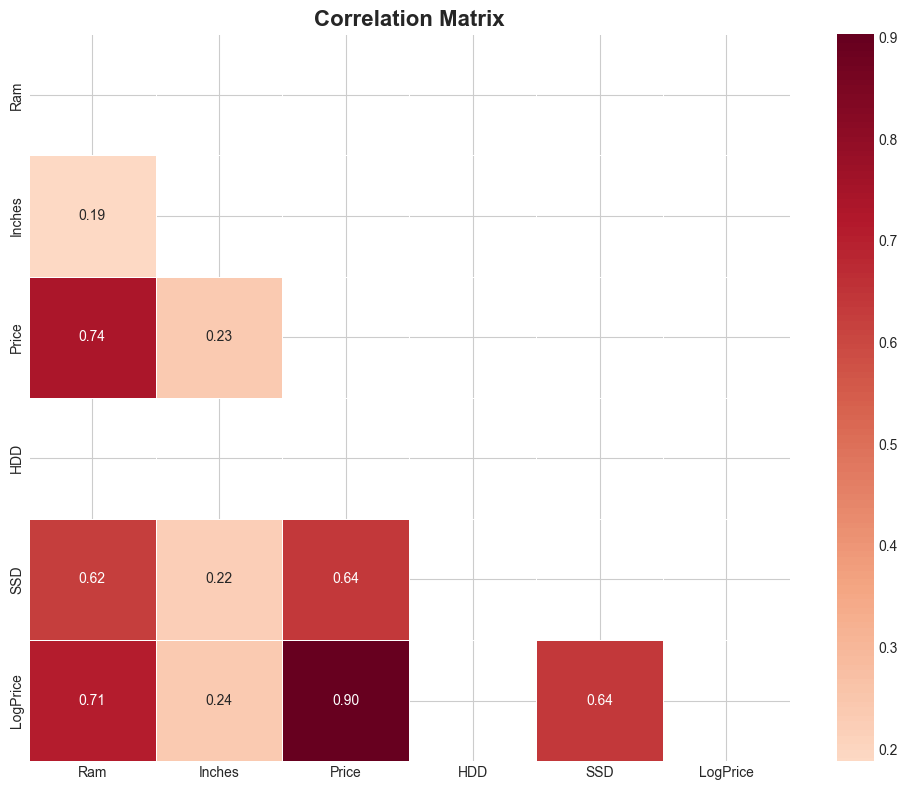

In [13]:
# Chọn các cột số
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f'Các cột số: {numerical_cols}')

# Ma trận tương quan
corr_matrix = df[numerical_cols].corr()

# Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0, 
            fmt='.2f', linewidths=0.5, ax=ax)
ax.set_title('Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

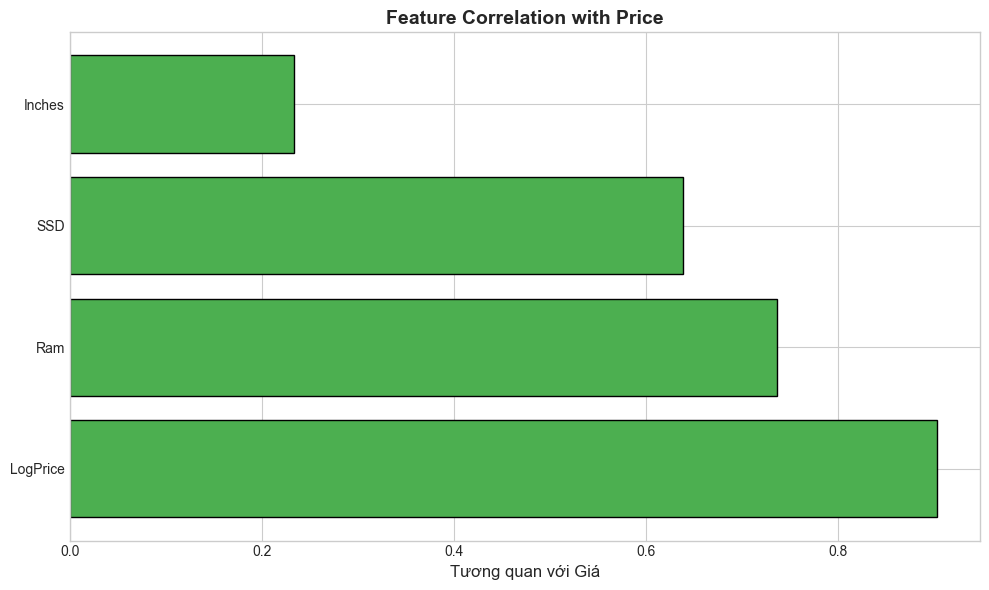


Tương quan với Giá:
   LogPrice       :    0.903
   Ram            :    0.737
   SSD            :    0.639
   Inches         :    0.234
   HDD            :      nan


In [14]:
# Tương quan với Giá
price_corr = corr_matrix['Price'].drop('Price').sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#4CAF50' if x > 0 else '#F44336' for x in price_corr.values]
ax.barh(price_corr.index, price_corr.values, color=colors, edgecolor='black')
ax.set_xlabel('Tương quan với Giá', fontsize=12)
ax.set_title('Feature Correlation with Price', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

print('\nTương quan với Giá:')
print('=' * 40)
for idx, val in price_corr.items():
    print(f'   {idx:<15}: {val:>8.3f}')

---
## 4. Data Preprocessing

In [15]:
# Tạo bản sao để xử lý
df_processed = df.copy()

# Xóa bản ghi trùng lặp
initial_len = len(df_processed)
df_processed = df_processed.drop_duplicates()
print(f'Đã xóa {initial_len - len(df_processed)} bản ghi trùng lặp')
print(f'Kích thước dataset: {len(df_processed)} bản ghi')

Đã xóa 0 bản ghi trùng lặp
Kích thước dataset: 893 bản ghi


In [16]:
# Tạo cột storage_gb từ SSD + HDD
df_processed['storage_gb'] = df_processed['SSD'] + df_processed['HDD']
df_processed.loc[df_processed['storage_gb'] == 0, 'storage_gb'] = 256  # Giá trị mặc định

# Đổi tên cột cho nhất quán
df_processed = df_processed.rename(columns={
    'Company': 'brand',
    'Ram': 'ram_gb',
    'Inches': 'screen_size',
    'Price': 'price',
    'OpSys': 'os',
    'Cpu': 'processor',
    'Gpu': 'gpu'
})

print('Đã đổi tên cột và tạo storage_gb')
df_processed.head()

Đã đổi tên cột và tạo storage_gb


,brand,Product,processor,ram_gb,gpu,os,screen_size,price,Cpu_brand,Gpu_brand,HDD,SSD,LogPrice,storage_gb
0,HP,Victus 15-fb0157AX Gaming Laptop,"Hexa Core, 12 Threads",8,4GB AMD Radeon RX 6500M,Windows 11 OS,15.6,49900,"Hexa Core,",4GB,0,512,10.817776,512
1,HP,15s-fq5007TU Laptop,"Hexa Core (2P + 4E), 8 Threads",8,Intel UHD Graphics,Windows 11 OS,15.6,39900,Hexa Core,Intel,0,512,10.594132,512
2,Acer,One 14 Z8-415 Laptop,"Dual Core, 4 Threads",8,Intel Iris Xe Graphics,Windows 11 OS,14.0,26990,"Dual Core,",Intel,0,512,10.203222,512
3,Lenovo,Yoga Slim 6 14IAP8 82WU0095IN Laptop,"12 Cores (4P + 8E), 16 Threads",16,Intel Integrated Iris Xe,Windows 11 OS,14.0,59729,12 Cores,Intel,0,512,10.997573,512
4,Apple,MacBook Air 2020 MGND3HN Laptop,Octa Core (4P + 4E),8,Apple M1 Integrated Graphics,Mac OS,13.3,69990,Octa Core,Apple,0,256,11.156108,256


---
## 5. Feature Engineering

In [17]:
# Hàm tính điểm Processor
def get_processor_score(cpu_str):
    if pd.isna(cpu_str):
        return 5
    cpu = str(cpu_str).lower()
    
    if '14 core' in cpu or '16 core' in cpu:
        return 9
    elif '12 core' in cpu or 'octa core' in cpu:
        return 8
    elif '10 core' in cpu:
        return 7
    elif 'hexa core' in cpu:
        return 6
    elif 'quad core' in cpu:
        return 5
    elif 'dual core' in cpu:
        return 3
    return 5

# Hàm tính điểm GPU
def get_gpu_score(gpu_str):
    if pd.isna(gpu_str):
        return 3
    gpu = str(gpu_str).lower()
    
    if any(x in gpu for x in ['4090', '4080']):
        return 10
    elif any(x in gpu for x in ['4070', '4060']):
        return 8
    elif '4050' in gpu:
        return 7
    elif any(x in gpu for x in ['3080', '3070']):
        return 8
    elif '3060' in gpu:
        return 7
    elif '3050' in gpu:
        return 6
    elif any(x in gpu for x in ['2050', '1660']):
        return 5
    elif any(x in gpu for x in ['1650', 'mx']):
        return 4
    elif any(x in gpu for x in ['iris', 'xe']):
        return 3
    elif any(x in gpu for x in ['intel', 'uhd', 'integrated']):
        return 2
    return 3

# Áp dụng feature engineering
df_processed['processor_score'] = df_processed['processor'].apply(get_processor_score)
df_processed['gpu_score'] = df_processed['gpu'].apply(get_gpu_score)

# Điểm hiệu năng tổng hợp
df_processed['performance_score'] = (
    df_processed['processor_score'] * 0.4 +
    df_processed['gpu_score'] * 0.3 +
    (df_processed['ram_gb'] / 64) * 10 * 0.2 +
    (df_processed['storage_gb'] / 2048) * 10 * 0.1
)

# Laptop gaming hay không
df_processed['is_gaming'] = df_processed['Product'].str.lower().str.contains('gaming', na=False).astype(int)

print('Đã hoàn thành Feature Engineering!')
print('\nCác đặc trưng mới:')
print('   - processor_score')
print('   - gpu_score')
print('   - performance_score')
print('   - is_gaming')

Đã hoàn thành Feature Engineering!

Các đặc trưng mới:
   - processor_score
   - gpu_score
   - performance_score
   - is_gaming


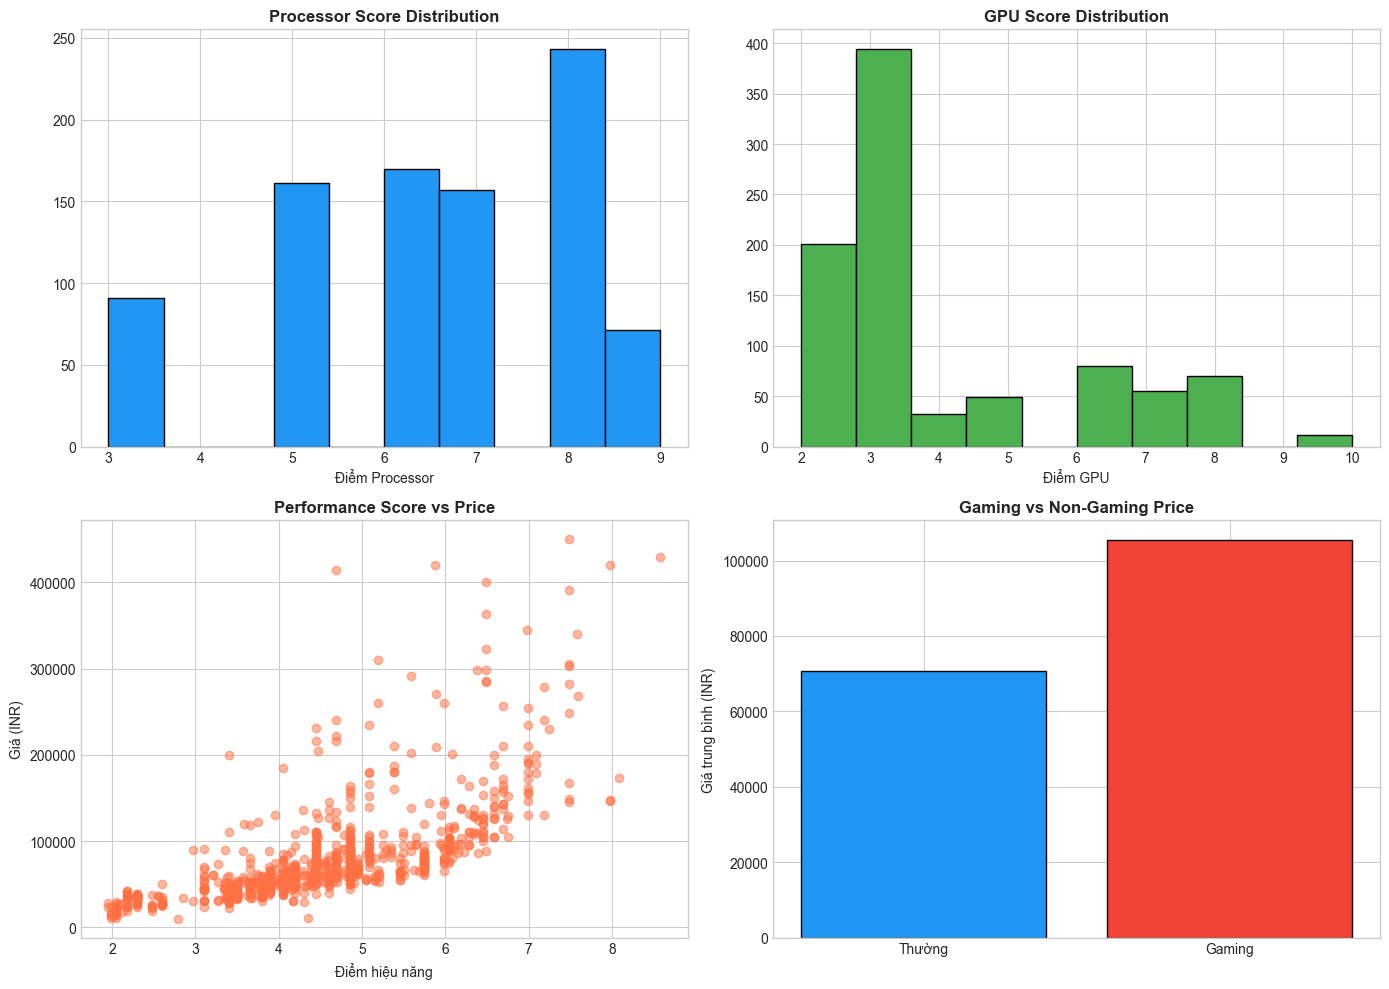

In [18]:
# Trực quan hóa các đặc trưng mới
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Phân phối điểm processor
axes[0, 0].hist(df_processed['processor_score'], bins=10, edgecolor='black', color='#2196F3')
axes[0, 0].set_xlabel('Điểm Processor')
axes[0, 0].set_title('Processor Score Distribution', fontweight='bold')

# Phân phối điểm GPU
axes[0, 1].hist(df_processed['gpu_score'], bins=10, edgecolor='black', color='#4CAF50')
axes[0, 1].set_xlabel('Điểm GPU')
axes[0, 1].set_title('GPU Score Distribution', fontweight='bold')

# Điểm hiệu năng vs Giá
axes[1, 0].scatter(df_processed['performance_score'], df_processed['price'], alpha=0.5, c='#FF7043')
axes[1, 0].set_xlabel('Điểm hiệu năng')
axes[1, 0].set_ylabel('Giá (INR)')
axes[1, 0].set_title('Performance Score vs Price', fontweight='bold')

# Gaming vs Non-Gaming
gaming_price = df_processed.groupby('is_gaming')['price'].mean()
axes[1, 1].bar(['Thường', 'Gaming'], gaming_price.values, color=['#2196F3', '#F44336'], edgecolor='black')
axes[1, 1].set_ylabel('Giá trung bình (INR)')
axes[1, 1].set_title('Gaming vs Non-Gaming Price', fontweight='bold')

plt.tight_layout()
plt.show()

### 5.1 Encode Categorical Features

In [19]:
# Mã hóa Label Encoding cho các cột phân loại
label_encoders = {}
categorical_cols = ['brand', 'os', 'processor', 'gpu']

for col in categorical_cols:
    if col in df_processed.columns:
        le = LabelEncoder()
        df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le
        print(f'Đã mã hóa {col}: {len(le.classes_)} giá trị duy nhất')

print(f'\nTổng số đặc trưng đã mã hóa: {len(label_encoders)}')

Đã mã hóa brand: 30 giá trị duy nhất
Đã mã hóa os: 14 giá trị duy nhất
Đã mã hóa processor: 29 giá trị duy nhất
Đã mã hóa gpu: 134 giá trị duy nhất

Tổng số đặc trưng đã mã hóa: 4


---
## 6. Model Training

### 6.1 Prepare Data for Training

In [20]:
# Chọn các đặc trưng để huấn luyện
feature_cols = [
    'ram_gb', 'storage_gb', 'screen_size',
    'processor_score', 'gpu_score', 'performance_score', 'is_gaming',
    'brand_encoded', 'os_encoded'
]

# Lọc các cột có sẵn
available_features = [col for col in feature_cols if col in df_processed.columns]
print(f'Các đặc trưng sử dụng: {available_features}')

# Chuẩn bị X và y
X = df_processed[available_features]
y = df_processed['price']

print(f'\nKích thước X: {X.shape}')
print(f'Kích thước y: {y.shape}')

Các đặc trưng sử dụng: ['ram_gb', 'storage_gb', 'screen_size', 'processor_score', 'gpu_score', 'performance_score', 'is_gaming', 'brand_encoded', 'os_encoded']

Kích thước X: (893, 9)
Kích thước y: (893,)


In [21]:
# Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'Tập huấn luyện: {X_train.shape}')
print(f'Tập kiểm tra: {X_test.shape}')

# Chuẩn hóa đặc trưng
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('\nĐã chia và chuẩn hóa dữ liệu thành công!')

Tập huấn luyện: (714, 9)
Tập kiểm tra: (179, 9)

Đã chia và chuẩn hóa dữ liệu thành công!


### 6.2 Train Multiple Models

In [22]:
# Khởi tạo các mô hình
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
}

# Huấn luyện và đánh giá
results = {}

print('=' * 70)
print('HUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH')
print('=' * 70)

for name, model in models.items():
    print(f'\nĐang huấn luyện {name}...')
    
    # Huấn luyện
    model.fit(X_train_scaled, y_train)
    
    # Dự đoán
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Tính các chỉ số
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores.mean()
    
    # Lưu kết quả
    results[name] = {
        'model': model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'cv_rmse': cv_rmse,
        'predictions': y_test_pred
    }
    
    print(f'   Test RMSE: {test_rmse:,.0f} INR')
    print(f'   Test MAE:  {test_mae:,.0f} INR')
    print(f'   Test R2:   {test_r2:.4f}')
    print(f'   CV RMSE:   {cv_rmse:,.0f} INR')

HUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH

Đang huấn luyện Linear Regression...
   Test RMSE: 33,114 INR
   Test MAE:  23,001 INR
   Test R2:   0.6800
   CV RMSE:   35,661 INR

Đang huấn luyện Random Forest...
   Test RMSE: 27,853 INR
   Test MAE:  14,519 INR
   Test R2:   0.7736
   CV RMSE:   31,952 INR

Đang huấn luyện Gradient Boosting...
   Test RMSE: 25,769 INR
   Test MAE:  13,676 INR
   Test R2:   0.8062
   CV RMSE:   32,721 INR


---
## 7. Model Evaluation

### 7.1 Model Comparison

In [23]:
# Tạo bảng so sánh
comparison_df = pd.DataFrame({
    'Mô hình': list(results.keys()),
    'Test RMSE (INR)': [results[m]['test_rmse'] for m in results],
    'Test MAE (INR)': [results[m]['test_mae'] for m in results],
    'Test R2': [results[m]['test_r2'] for m in results],
    'CV RMSE (INR)': [results[m]['cv_rmse'] for m in results]
})

comparison_df = comparison_df.round(2)
print('Bảng so sánh các mô hình:')
print('=' * 80)
print(comparison_df.to_string(index=False))

Bảng so sánh các mô hình:
          Mô hình  Test RMSE (INR)  Test MAE (INR)  Test R2  CV RMSE (INR)
Linear Regression         33114.33        23001.43     0.68       35660.91
    Random Forest         27852.77        14518.97     0.77       31951.57
Gradient Boosting         25768.84        13675.98     0.81       32721.29


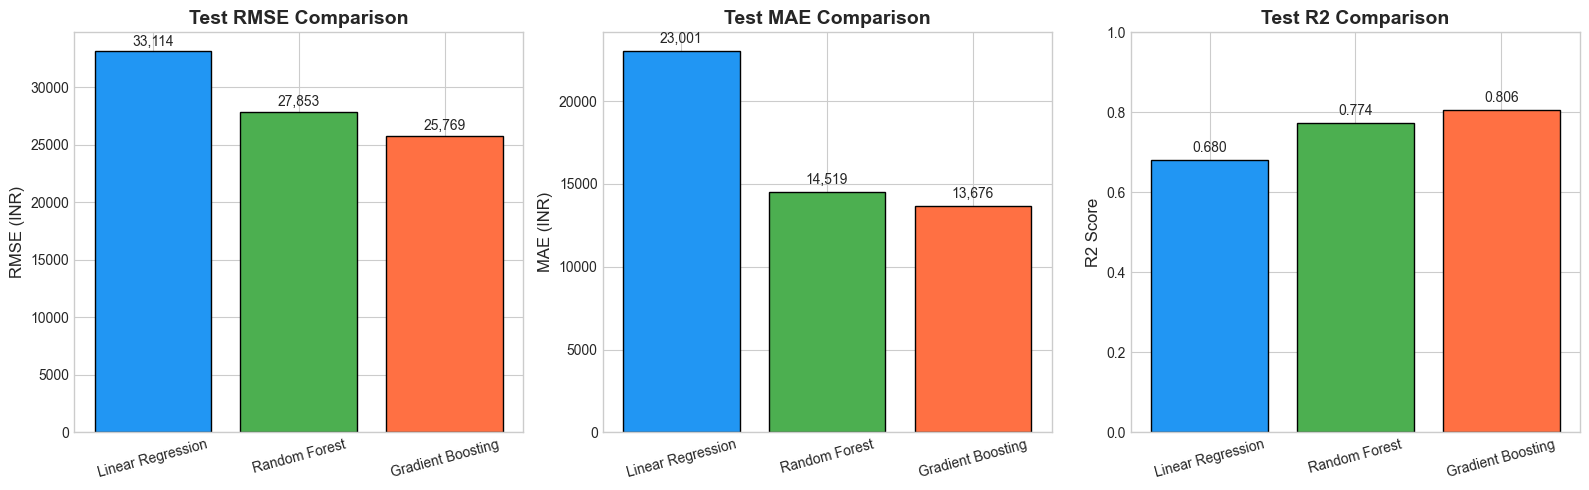

In [24]:
# Trực quan hóa so sánh mô hình
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

models_names = list(results.keys())
colors = ['#2196F3', '#4CAF50', '#FF7043']

# So sánh RMSE
rmse_values = [results[m]['test_rmse'] for m in models_names]
axes[0].bar(models_names, rmse_values, color=colors, edgecolor='black')
axes[0].set_ylabel('RMSE (INR)', fontsize=12)
axes[0].set_title('Test RMSE Comparison', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=15)
for i, v in enumerate(rmse_values):
    axes[0].text(i, v + 500, f'{v:,.0f}', ha='center', fontsize=10)

# So sánh MAE
mae_values = [results[m]['test_mae'] for m in models_names]
axes[1].bar(models_names, mae_values, color=colors, edgecolor='black')
axes[1].set_ylabel('MAE (INR)', fontsize=12)
axes[1].set_title('Test MAE Comparison', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=15)
for i, v in enumerate(mae_values):
    axes[1].text(i, v + 500, f'{v:,.0f}', ha='center', fontsize=10)

# So sánh R2
r2_values = [results[m]['test_r2'] for m in models_names]
axes[2].bar(models_names, r2_values, color=colors, edgecolor='black')
axes[2].set_ylabel('R2 Score', fontsize=12)
axes[2].set_title('Test R2 Comparison', fontsize=14, fontweight='bold')
axes[2].tick_params(axis='x', rotation=15)
axes[2].set_ylim(0, 1)
for i, v in enumerate(r2_values):
    axes[2].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### 7.2 Actual vs Predicted Plot

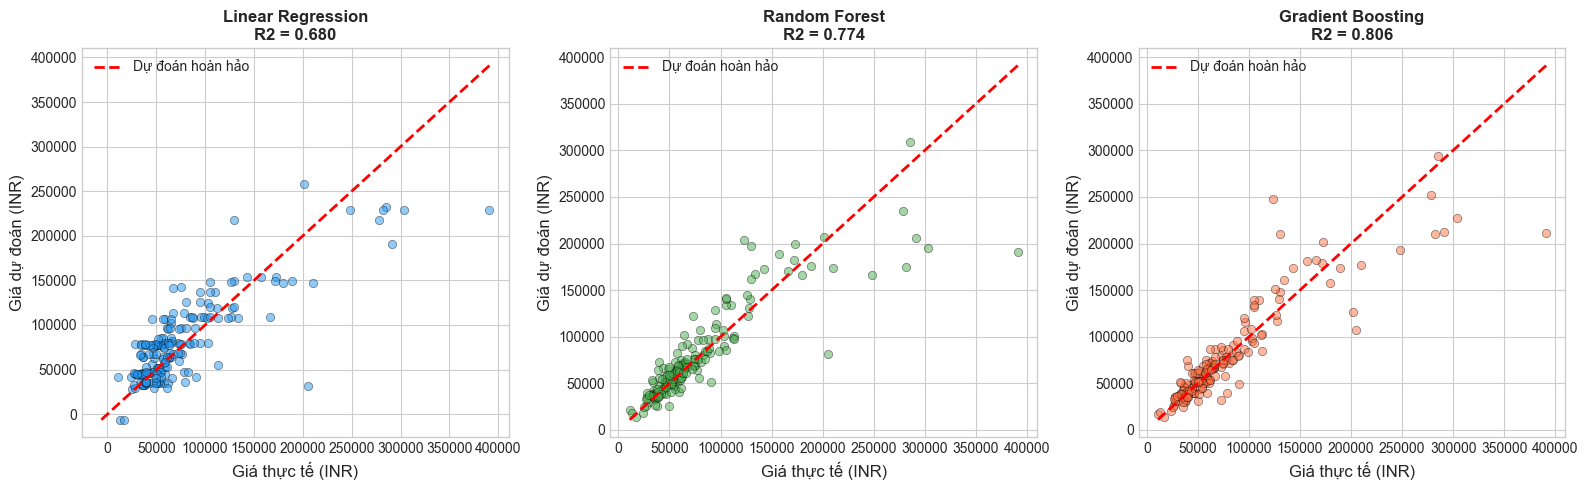

In [25]:
# Thực tế vs Dự đoán cho tất cả mô hình
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (name, res) in enumerate(results.items()):
    ax = axes[idx]
    
    ax.scatter(y_test, res['predictions'], alpha=0.5, c=colors[idx], edgecolors='black', linewidth=0.5)
    
    # Đường dự đoán hoàn hảo
    min_val = min(y_test.min(), res['predictions'].min())
    max_val = max(y_test.max(), res['predictions'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Dự đoán hoàn hảo')
    
    ax.set_xlabel('Giá thực tế (INR)', fontsize=12)
    ax.set_ylabel('Giá dự đoán (INR)', fontsize=12)
    ax.set_title(f'{name}\nR2 = {res["test_r2"]:.3f}', fontsize=12, fontweight='bold')
    ax.legend()

plt.tight_layout()
plt.show()

### 7.3 Residual Analysis

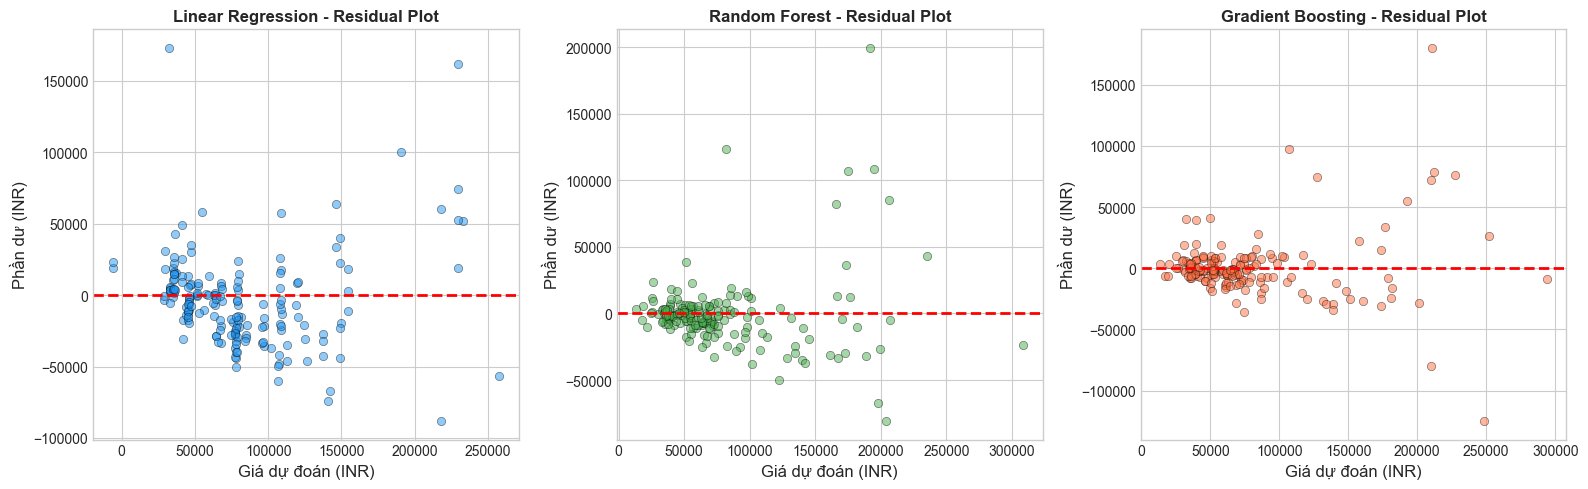

In [26]:
# Biểu đồ phần dư
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (name, res) in enumerate(results.items()):
    ax = axes[idx]
    residuals = y_test.values - res['predictions']
    
    ax.scatter(res['predictions'], residuals, alpha=0.5, c=colors[idx], edgecolors='black', linewidth=0.5)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
    
    ax.set_xlabel('Giá dự đoán (INR)', fontsize=12)
    ax.set_ylabel('Phần dư (INR)', fontsize=12)
    ax.set_title(f'{name} - Residual Plot', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 8. Feature Importance

In [27]:
# Lấy độ quan trọng đặc trưng từ mô hình tốt nhất
best_model_name = max(results.keys(), key=lambda x: results[x]['test_r2'])
best_model = results[best_model_name]['model']

print(f'Mô hình tốt nhất: {best_model_name}')
print(f'   R2 Score: {results[best_model_name]["test_r2"]:.4f}')

if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Đặc trưng': available_features,
        'Độ quan trọng': best_model.feature_importances_
    }).sort_values('Độ quan trọng', ascending=False)
    
    print('\nĐộ quan trọng đặc trưng:')
    print('=' * 40)
    for _, row in importance_df.iterrows():
        print(f'   {row["Đặc trưng"]:<20}: {row["Độ quan trọng"]:.4f}')

Mô hình tốt nhất: Gradient Boosting
   R2 Score: 0.8062

Độ quan trọng đặc trưng:
   ram_gb              : 0.3468
   performance_score   : 0.2601
   storage_gb          : 0.0918
   gpu_score           : 0.0828
   processor_score     : 0.0768
   screen_size         : 0.0582
   brand_encoded       : 0.0400
   os_encoded          : 0.0354
   is_gaming           : 0.0082


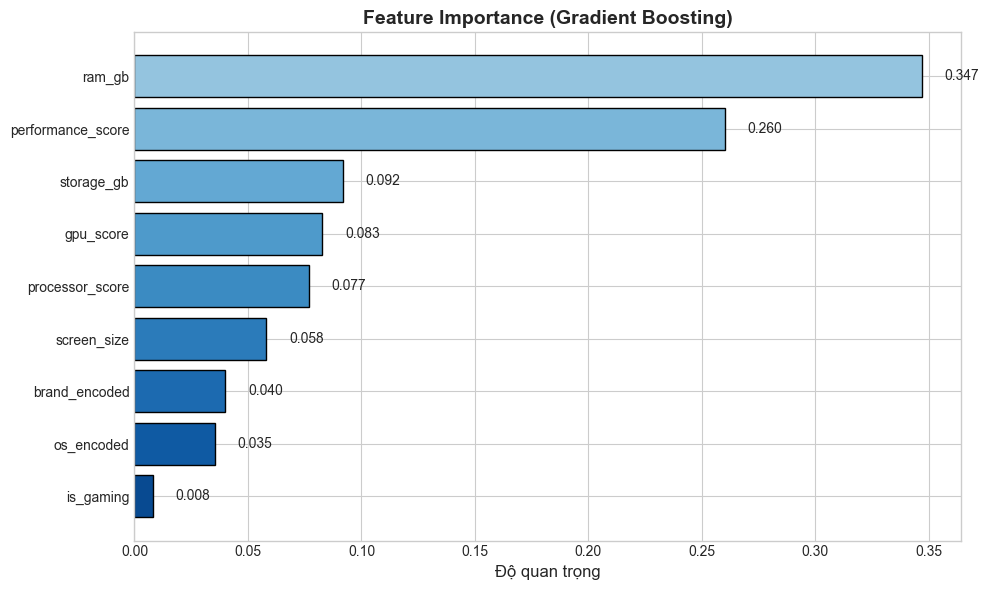

In [28]:
# Trực quan hóa độ quan trọng đặc trưng
if hasattr(best_model, 'feature_importances_'):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors_imp = plt.cm.Blues(np.linspace(0.4, 0.9, len(importance_df)))
    bars = ax.barh(importance_df['Đặc trưng'], importance_df['Độ quan trọng'], color=colors_imp, edgecolor='black')
    ax.set_xlabel('Độ quan trọng', fontsize=12)
    ax.set_title(f'Feature Importance ({best_model_name})', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    
    # Thêm nhãn giá trị
    for bar, val in zip(bars, importance_df['Độ quan trọng']):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

---
## 9. Conclusion

In [29]:
print('=' * 70)
print('TÓM TẮT DỰ ÁN')
print('=' * 70)

print(f'''
Mục tiêu: Dự đoán giá laptop dựa trên cấu hình

Dataset:
   - Nguồn: Kaggle - Laptop Price Estimation
   - Tổng số bản ghi: {len(df):,}
   - Số đặc trưng sử dụng: {len(available_features)}
   - Biến mục tiêu: Giá (INR - Rupee Ấn Độ)

Tiền xử lý:
   - Xử lý giá trị thiếu
   - Xóa bản ghi trùng lặp
   - Tạo storage_gb từ SSD + HDD
   - Mã hóa các đặc trưng phân loại
   - Chuẩn hóa đặc trưng bằng StandardScaler

Feature Engineering:
   - processor_score (dựa trên số nhân)
   - gpu_score (dựa trên model GPU)
   - performance_score (kết hợp có trọng số)
   - is_gaming (từ tên sản phẩm)

Các mô hình đã huấn luyện:
''')

for name, res in results.items():
    marker = '(Tốt nhất)' if name == best_model_name else ''
    print(f'   {name} {marker}:')
    print(f'      - Test R2: {res["test_r2"]:.4f}')
    print(f'      - Test RMSE: {res["test_rmse"]:,.0f} INR')
    print(f'      - Test MAE: {res["test_mae"]:,.0f} INR')

print(f'''
Mô hình tốt nhất: {best_model_name}
   - R2 Score: {results[best_model_name]["test_r2"]:.4f}
   - RMSE: {results[best_model_name]["test_rmse"]:,.0f} INR
   - MAE: {results[best_model_name]["test_mae"]:,.0f} INR

Nhận xét chính:
   1. RAM và performance_score là các yếu tố dự đoán quan trọng nhất
   2. Laptop gaming thường có giá cao hơn
   3. Laptop Apple có giá trung bình cao nhất
   4. Mô hình tree-based vượt trội hơn Linear Regression
   5. Feature engineering cải thiện hiệu suất mô hình
''')

print('=' * 70)
print('Hoàn thành dự án!')
print('=' * 70)

TÓM TẮT DỰ ÁN

Mục tiêu: Dự đoán giá laptop dựa trên cấu hình

Dataset:
   - Nguồn: Kaggle - Laptop Price Estimation
   - Tổng số bản ghi: 893
   - Số đặc trưng sử dụng: 9
   - Biến mục tiêu: Giá (INR - Rupee Ấn Độ)

Tiền xử lý:
   - Xử lý giá trị thiếu
   - Xóa bản ghi trùng lặp
   - Tạo storage_gb từ SSD + HDD
   - Mã hóa các đặc trưng phân loại
   - Chuẩn hóa đặc trưng bằng StandardScaler

Feature Engineering:
   - processor_score (dựa trên số nhân)
   - gpu_score (dựa trên model GPU)
   - performance_score (kết hợp có trọng số)
   - is_gaming (từ tên sản phẩm)

Các mô hình đã huấn luyện:

   Linear Regression :
      - Test R2: 0.6800
      - Test RMSE: 33,114 INR
      - Test MAE: 23,001 INR
   Random Forest :
      - Test R2: 0.7736
      - Test RMSE: 27,853 INR
      - Test MAE: 14,519 INR
   Gradient Boosting (Tốt nhất):
      - Test R2: 0.8062
      - Test RMSE: 25,769 INR
      - Test MAE: 13,676 INR

Mô hình tốt nhất: Gradient Boosting
   - R2 Score: 0.8062
   - RMSE: 25,769

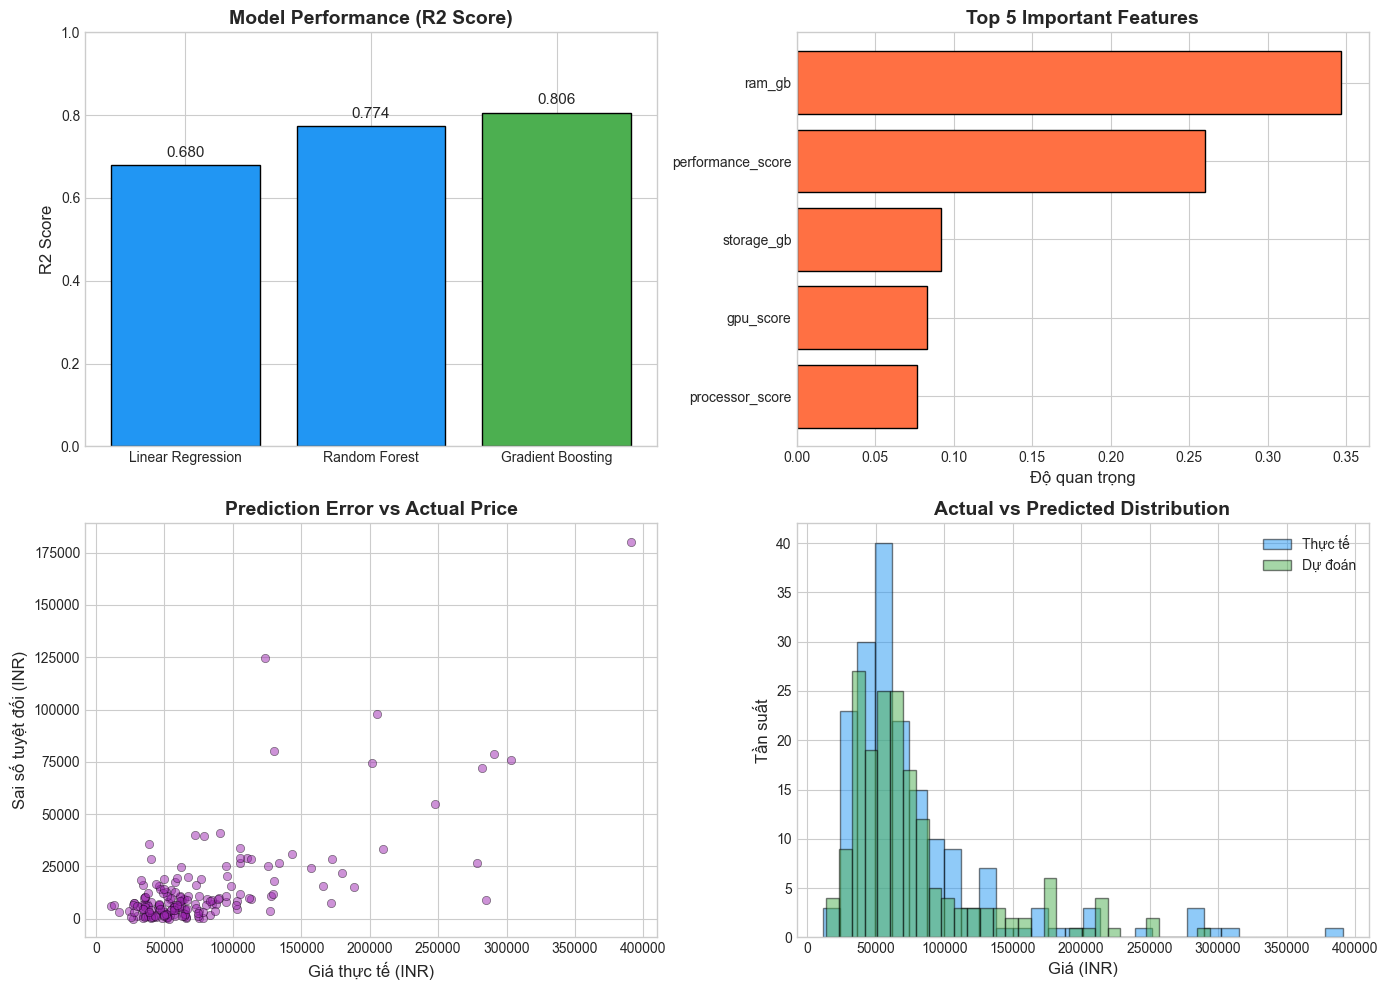


Đã hoàn thành notebook!


In [30]:
# Biểu đồ tóm tắt cuối cùng
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Hiệu suất mô hình
ax = axes[0, 0]
models_names = list(results.keys())
r2_scores = [results[m]['test_r2'] for m in models_names]
colors_bar = ['#4CAF50' if m == best_model_name else '#2196F3' for m in models_names]
bars = ax.bar(models_names, r2_scores, color=colors_bar, edgecolor='black')
ax.set_ylabel('R2 Score', fontsize=12)
ax.set_title('Model Performance (R2 Score)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
for bar, score in zip(bars, r2_scores):
    ax.text(bar.get_x() + bar.get_width()/2, score + 0.02, f'{score:.3f}', ha='center', fontsize=11)

# 2. Độ quan trọng đặc trưng
ax = axes[0, 1]
if hasattr(best_model, 'feature_importances_'):
    top_features = importance_df.head(5)
    ax.barh(top_features['Đặc trưng'], top_features['Độ quan trọng'], color='#FF7043', edgecolor='black')
    ax.set_xlabel('Độ quan trọng', fontsize=12)
    ax.set_title('Top 5 Important Features', fontsize=14, fontweight='bold')
    ax.invert_yaxis()

# 3. Sai số dự đoán
ax = axes[1, 0]
best_preds = results[best_model_name]['predictions']
errors = np.abs(y_test.values - best_preds)
ax.scatter(y_test, errors, alpha=0.5, c='#9C27B0', edgecolors='black', linewidth=0.5)
ax.set_xlabel('Giá thực tế (INR)', fontsize=12)
ax.set_ylabel('Sai số tuyệt đối (INR)', fontsize=12)
ax.set_title('Prediction Error vs Actual Price', fontsize=14, fontweight='bold')

# 4. Phân phối Thực tế vs Dự đoán
ax = axes[1, 1]
ax.hist(y_test, bins=30, alpha=0.5, label='Thực tế', color='#2196F3', edgecolor='black')
ax.hist(best_preds, bins=30, alpha=0.5, label='Dự đoán', color='#4CAF50', edgecolor='black')
ax.set_xlabel('Giá (INR)', fontsize=12)
ax.set_ylabel('Tần suất', fontsize=12)
ax.set_title('Actual vs Predicted Distribution', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

print('\nĐã hoàn thành notebook!')